This script is to generate a rough plate with a hole in the center.

* A square rough profile will be generated first. 
* A cirle will be cut in the center of the square.

# Install and import necessary toolbox

In [117]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RectBivariateSpline
import os
from scipy.spatial import KDTree
import pandas as pd
import time
import sys
import gmsh

In [118]:

volume_hole_file_folder = 'C:\\Abaqus_Works\\roughness_simulation'

rough_or_flat = "rough"

file_name_gmsh = f"gmsh_hole_{rough_or_flat}.inp"
file_name_abaqus = f"abaqus_hole_{rough_or_flat}.inp"
file_name_input_xlsx = f"input_hole_{rough_or_flat}.xlsx"

print(file_name_abaqus)
if rough_or_flat == "flat":
    print(f"right on flat")
else:
    print(f"right on rough")

abaqus_hole_rough.inp
right on rough


# Determine the size and control points of 2-D spline

*   Define the range of the volume on X-Y plane

    [Smaller size will be cropped form this volume]
*   Define the interval of control points along X and Y axes

    [Denser points will be interpolated by the fitted spline]
*   Define the thickness of the plate
*   Define Ra in unit 'mm'
*   If necessary, the range can be adjusted into [0.1, 0.5] with increment of 0.005.(not necessary any more 2025/02/20)
* By doing this, ***even*** number of structured grids can be achieved (not necessary any more 2025/02/20)


In [119]:
#-------------------------------------------------------------------------------
# Define original size and parameters about the control points
#-------------------------------------------------------------------------------
# define the range for the point series
range_low_control_points = -0.6 # (mm)
range_upp_control_points = +0.6 # (mm)

# Define the interval of control points in the unit of 'mm'
interval_control_points = 0.060 # unit of 'mm' about half of the hatching distance
number_control_points = int((range_upp_control_points - range_low_control_points)/interval_control_points) + 1
print(f'The number of control points along one direction is {number_control_points}')

x_1D_control_points = np.linspace(range_low_control_points, range_upp_control_points, number_control_points)
y_1D_control_points = np.linspace(range_low_control_points, range_upp_control_points, number_control_points)
print(x_1D_control_points)

#-------------------------------------------------------------------------------
# Define the structured grids which should be denser or smaller than control points
#-------------------------------------------------------------------------------
range_low_struct_grids = range_low_control_points  # (mm)
range_upp_struct_grids = range_upp_control_points  # (mm)

#-------------------------------------------------------------------------------
# Define thickness and roughness Ra
#-------------------------------------------------------------------------------
# Define the plate thickness in the unit of mm
thickness = 0.1 # unit of mm
# Ra in the unit of mm
Ra = 0.005      # unit of mm

print(f'The thickness of the volume and roughness are {thickness} mm {Ra} mm respectively.')

#-------------------------------------------------------------------------------
# Define the structured grids which should be denser than control points
#-------------------------------------------------------------------------------
# Define the interval of structured grid which is denser than the control points
elem_sub_times = 1.0
interval_basis = 0.004
interval_struct_grids = interval_basis/elem_sub_times #300.0/147.0*0.001/elem_sub_times   #   with unit of 'mm'
print(f"The interval of the structured grids is {interval_struct_grids} mm")

# Number of the structured grids along X- or Y-axes
number_struct_grids = round((range_upp_struct_grids - range_low_struct_grids)/interval_struct_grids) + 1
print(f"number of structured grids along one direction is {number_struct_grids}")

#-------------------------------------------------------------------------------
# Define the range of the structured grids
# Structured grids are not necessary to be overlapped with control points
#-------------------------------------------------------------------------------
x_1D_struct_grids = np.linspace(range_low_struct_grids, range_upp_struct_grids, number_struct_grids)
y_1D_struct_grids = np.linspace(range_low_struct_grids, range_upp_struct_grids, number_struct_grids)
X_2D_struct_grids, Y_2D_struct_grids = np.meshgrid(x_1D_struct_grids, y_1D_struct_grids)

print(x_1D_struct_grids)
print(len(x_1D_struct_grids))

# dense grids to measure the roughness
interval_dense_points = 0.002   # unit of mm
number_dense_grids = int((range_upp_control_points - range_low_control_points)/interval_dense_points) + 1
x_1D_dense_grids = np.linspace(range_low_control_points, range_upp_control_points, number_dense_grids)
y_1D_dense_grids = np.linspace(range_low_control_points, range_upp_control_points, number_dense_grids)
# print(x_1D_dense_grids)

The number of control points along one direction is 21
[-0.6  -0.54 -0.48 -0.42 -0.36 -0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06
  0.12  0.18  0.24  0.3   0.36  0.42  0.48  0.54  0.6 ]
The thickness of the volume and roughness are 0.1 mm 0.005 mm respectively.
The interval of the structured grids is 0.004 mm
number of structured grids along one direction is 301
[-0.6   -0.596 -0.592 -0.588 -0.584 -0.58  -0.576 -0.572 -0.568 -0.564
 -0.56  -0.556 -0.552 -0.548 -0.544 -0.54  -0.536 -0.532 -0.528 -0.524
 -0.52  -0.516 -0.512 -0.508 -0.504 -0.5   -0.496 -0.492 -0.488 -0.484
 -0.48  -0.476 -0.472 -0.468 -0.464 -0.46  -0.456 -0.452 -0.448 -0.444
 -0.44  -0.436 -0.432 -0.428 -0.424 -0.42  -0.416 -0.412 -0.408 -0.404
 -0.4   -0.396 -0.392 -0.388 -0.384 -0.38  -0.376 -0.372 -0.368 -0.364
 -0.36  -0.356 -0.352 -0.348 -0.344 -0.34  -0.336 -0.332 -0.328 -0.324
 -0.32  -0.316 -0.312 -0.308 -0.304 -0.3   -0.296 -0.292 -0.288 -0.284
 -0.28  -0.276 -0.272 -0.268 -0.264 -0.26  -0.256 -0.252 -0.248 -0.24

Define the cropped structured grids parameters

In [120]:
#-------------------------------------------------------------------------------
# Define the cropped structured grids
#-------------------------------------------------------------------------------
number_crop_struct_grids = number_struct_grids 
print(f"number of cropped structured grids along one direction is {number_crop_struct_grids}")

effective_crop_length = (number_crop_struct_grids-1)*interval_struct_grids
print(f"the effective length of the cropped structured grids is {round(effective_crop_length*1000)} um")

# Crop the structured grids into smaller size around the center
if (number_crop_struct_grids > number_struct_grids) or ((number_struct_grids-number_crop_struct_grids)%2 != 0):
    print("Error in cropping the structured grids!")

# crop the grids symmetrically about the center
index_start = 0
index_stop = number_struct_grids

x_1D_crop_struct_grids = x_1D_struct_grids[index_start:index_stop]
y_1D_crop_struct_grids = y_1D_struct_grids[index_start:index_stop]
print(x_1D_crop_struct_grids)
print(len(x_1D_crop_struct_grids))

#-------------------------------------------------------------------------------
# Define the element sizes for GMSH meshing
#-------------------------------------------------------------------------------
# mesh size of the characteristic length which will determine the element size
size_elem_fine = interval_struct_grids  # unit of mm
size_elem_rough = 0.02                  # unit of mm
print(f"fine and rough element size are {size_elem_fine} and {size_elem_rough}")

#-------------------------------------------------------------------------------
# Define the Young's moduli and Poisson's ratio and tensile strain amplitude
#-------------------------------------------------------------------------------
# volume young moduli, Poisson's ratio and shear moduli
volume_young_moduli = 121000.0
volume_possion_ratio = 0.308
volume_shear_moduli = volume_young_moduli/(2.0*(1.0 + volume_possion_ratio))

# tensile strain amplitude
nom_stress = 100.0 # unit of MPa
# strain_amp = 0.005
# print(f"The nominal strain is {strain_amp} mm/mm")


number of cropped structured grids along one direction is 301
the effective length of the cropped structured grids is 1200 um
[-0.6   -0.596 -0.592 -0.588 -0.584 -0.58  -0.576 -0.572 -0.568 -0.564
 -0.56  -0.556 -0.552 -0.548 -0.544 -0.54  -0.536 -0.532 -0.528 -0.524
 -0.52  -0.516 -0.512 -0.508 -0.504 -0.5   -0.496 -0.492 -0.488 -0.484
 -0.48  -0.476 -0.472 -0.468 -0.464 -0.46  -0.456 -0.452 -0.448 -0.444
 -0.44  -0.436 -0.432 -0.428 -0.424 -0.42  -0.416 -0.412 -0.408 -0.404
 -0.4   -0.396 -0.392 -0.388 -0.384 -0.38  -0.376 -0.372 -0.368 -0.364
 -0.36  -0.356 -0.352 -0.348 -0.344 -0.34  -0.336 -0.332 -0.328 -0.324
 -0.32  -0.316 -0.312 -0.308 -0.304 -0.3   -0.296 -0.292 -0.288 -0.284
 -0.28  -0.276 -0.272 -0.268 -0.264 -0.26  -0.256 -0.252 -0.248 -0.244
 -0.24  -0.236 -0.232 -0.228 -0.224 -0.22  -0.216 -0.212 -0.208 -0.204
 -0.2   -0.196 -0.192 -0.188 -0.184 -0.18  -0.176 -0.172 -0.168 -0.164
 -0.16  -0.156 -0.152 -0.148 -0.144 -0.14  -0.136 -0.132 -0.128 -0.124
 -0.12  -0.116 -0.112 

* Generate random surface at the control points
* Fit the random control points with spline function
* The number of control points will determines the number of peaks and valleys
* Sampling the dense structured grids with the available spline interpolator



In [121]:
rand_seed = 143567
np.random.seed(rand_seed)
# Create random values for the control points
if rough_or_flat == "rough":
    Z_2D_control_points = np.random.uniform(-1, +1, size=(number_control_points, number_control_points))    # it is uniform distribution

if rough_or_flat == "flat":
    Z_2D_control_points = np.zeros((number_control_points, number_control_points))    # it is uniform distribution

# print(Z_2D_control_points.shape)

# fitting the control points and create the B-spline interpolator
random_spline_surface = RectBivariateSpline(x_1D_control_points, y_1D_control_points, Z_2D_control_points)

#************************************************************************************************************************
# calculate the roughness with the dense grid with the spacing of 1um
#************************************************************************************************************************
Z_2D_dense_grids = random_spline_surface(x_1D_dense_grids, y_1D_dense_grids)

mean_dense_grids = np.mean(Z_2D_dense_grids)

# shift the surface by mean_surface
shifted_mean_dense_grids = Z_2D_dense_grids - mean_dense_grids

# calculate the Ra (or average of the absolute mean)
mean_abs_shifted_dense_grids = np.mean(np.abs(shifted_mean_dense_grids))
print(f"mean value and Ra of the dense sampling is {mean_dense_grids} and {mean_abs_shifted_dense_grids}")
#************************************************************************************************************************

# Z = np.ones((number_struct_grids, number_struct_grids)) + thickness
# Sampling at the structured grids

x_shift_grid = 0
y_shift_gird = 0
print(f"x shift {x_shift_grid} and y shift {y_shift_gird}")

x_1D_sample_grid = x_1D_struct_grids + x_shift_grid*interval_struct_grids
y_1D_sample_grid = y_1D_struct_grids + y_shift_gird*interval_struct_grids

print(f'the sampling range in the X or Y axis')
print(x_1D_sample_grid)

# extract the dR/dx and dR/dy and save them
baseline_surface    = random_spline_surface(x_1D_sample_grid, y_1D_sample_grid)
dx_baseline_surface = random_spline_surface(x_1D_sample_grid, y_1D_sample_grid, dx=1, dy=0)
dy_baseline_surface = random_spline_surface(x_1D_sample_grid, y_1D_sample_grid, dx=0, dy=1)

if rough_or_flat == "rough":
    scaled_shifted_baseline_surface = (baseline_surface - mean_dense_grids)/mean_abs_shifted_dense_grids*Ra
else:
    scaled_shifted_baseline_surface = (baseline_surface - mean_dense_grids)
    
# dx_scaled_baseline_surface = dx_baseline_surface/mean_abs_shifted_dense_grids*Ra
# dy_scaled_baseline_surface = dy_baseline_surface/mean_abs_shifted_dense_grids*Ra

# shift the scaled surface to form a volume
Z_2D_struct_grids = scaled_shifted_baseline_surface + thickness
print(f"The shape of Z_2D_struct_grids is {Z_2D_struct_grids.shape}")
print(f"max {np.max(Z_2D_struct_grids)} min {np.min(Z_2D_struct_grids)}")
# print(f"make sure Ra is close to {np.max(Z_2D_struct_grids) - np.min(Z_2D_struct_grids)} (mm)")

index_start = 0
index_stop = number_struct_grids

print(f"index start {index_start} index stop {index_stop} in for the cropped structured grids")

Z_2D_crop_struct_grids = Z_2D_struct_grids[index_start:index_stop, index_start:index_stop]

# roughness values with mean at Z=0
R_2D_crop_struct_grids = scaled_shifted_baseline_surface[index_start:index_stop, index_start:index_stop]
# dx_2D_crop_struct_grids = dx_scaled_baseline_surface[index_start:index_stop, index_start:index_stop]
# dy_2D_crop_struct_grids = dy_scaled_baseline_surface[index_start:index_stop, index_start:index_stop]


mean value and Ra of the dense sampling is -0.05622160001667615 and 0.4364107048166169
x shift 0 and y shift 0
the sampling range in the X or Y axis
[-0.6   -0.596 -0.592 -0.588 -0.584 -0.58  -0.576 -0.572 -0.568 -0.564
 -0.56  -0.556 -0.552 -0.548 -0.544 -0.54  -0.536 -0.532 -0.528 -0.524
 -0.52  -0.516 -0.512 -0.508 -0.504 -0.5   -0.496 -0.492 -0.488 -0.484
 -0.48  -0.476 -0.472 -0.468 -0.464 -0.46  -0.456 -0.452 -0.448 -0.444
 -0.44  -0.436 -0.432 -0.428 -0.424 -0.42  -0.416 -0.412 -0.408 -0.404
 -0.4   -0.396 -0.392 -0.388 -0.384 -0.38  -0.376 -0.372 -0.368 -0.364
 -0.36  -0.356 -0.352 -0.348 -0.344 -0.34  -0.336 -0.332 -0.328 -0.324
 -0.32  -0.316 -0.312 -0.308 -0.304 -0.3   -0.296 -0.292 -0.288 -0.284
 -0.28  -0.276 -0.272 -0.268 -0.264 -0.26  -0.256 -0.252 -0.248 -0.244
 -0.24  -0.236 -0.232 -0.228 -0.224 -0.22  -0.216 -0.212 -0.208 -0.204
 -0.2   -0.196 -0.192 -0.188 -0.184 -0.18  -0.176 -0.172 -0.168 -0.164
 -0.16  -0.156 -0.152 -0.148 -0.144 -0.14  -0.136 -0.132 -0.128 -0.124

Setting the square hole size

In [122]:
# a hole will be cut in the center of the volume
indx_number_crop_ctrl = (number_crop_struct_grids - 1) // 2
half_number_crop_ctrl = 10

low_lim_crop_ctrl = indx_number_crop_ctrl - half_number_crop_ctrl
upp_lim_crop_ctrl = indx_number_crop_ctrl + half_number_crop_ctrl

void_index_surface = np.zeros((number_crop_struct_grids, number_crop_struct_grids), dtype=int)
for i in range(number_crop_struct_grids):
    for j in range(number_crop_struct_grids):
        # if the struct grid point is in the square hole
        if (low_lim_crop_ctrl < i) and (i < upp_lim_crop_ctrl) and (low_lim_crop_ctrl <j) and (j < upp_lim_crop_ctrl):
            # print(f"skip node at {i} and {j}")
            void_index_surface[i, j] = 1

#----------------------------------
# write the data into the file
#----------------------------------

rough_surface_file_path = os.path.join(volume_hole_file_folder, file_name_input_xlsx)

sheet_name_list = ['R','Void']

with pd.ExcelWriter(rough_surface_file_path, engine='openpyxl') as writer:

    # output the R
    sheet_name = f"{sheet_name_list[0]}"
    df = pd.DataFrame(R_2D_crop_struct_grids[:, :])
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

    # output the void
    sheet_name = f"{sheet_name_list[1]}"
    df = pd.DataFrame(void_index_surface[:, :])
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

Plot the rough surface in 3D

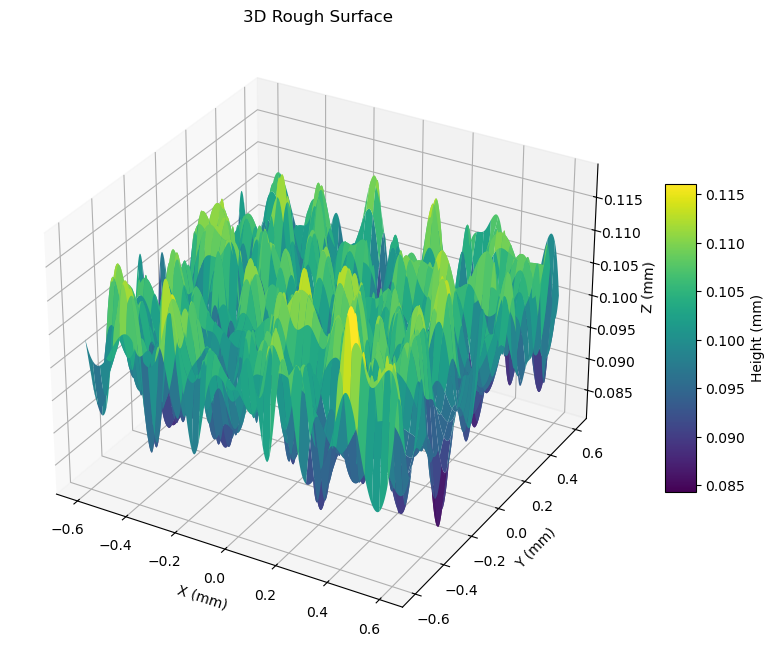

In [123]:
#Create a meshgrid from x_1D_crop_struct_grids and y_1D_crop_struct_grids
X, Y = np.meshgrid(x_1D_crop_struct_grids, y_1D_crop_struct_grids)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_surface to create the 3D plot
surf = ax.plot_surface(X, Y, Z_2D_crop_struct_grids, cmap='viridis', edgecolor='none')

# Add labels and a color bar
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('3D Rough Surface')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Height (mm)')

# Show the plot
plt.show()

# Generate random volume with rough surface

Generate model by GMSH

In [124]:
# Add lines and register them in the dictionary
def add_line(p1, p2, line_lookup):
    # sort the two points according to its number
    if p1 < p2:
        p_A = p1
        p_B = p2
    else:
        p_A = p2
        p_B = p1
    # construct tuple of two points on both sides of a line
    line = (p_A, p_B)
    if line in line_lookup:
        return False
    else:
        tag = len(line_lookup) + 1  # Unique tag
        gmsh.model.occ.addLine(p_A, p_B, tag)
        line_lookup[line] = tag  # Store with sorted points as key
        return True

# Retrieve a line tag by two points and direction
def get_line_tag(p1, p2, line_lookup):
    direction = 0
    if p1 < p2:
        p_A = p1
        p_B = p2
        direction = +1
    else:
        p_A = p2
        p_B = p1
        direction = -1
    line = (p_A, p_B)

    return line_lookup.get(line)*direction

In [125]:

# Initialize gmsh
gmsh.initialize()
gmsh.model.add("rough_surface_with_hole")



# Register points for the rough surface
node_number_surface = 0
node_index_surface = np.zeros((number_crop_struct_grids, number_crop_struct_grids), dtype=int)
for i in range(number_crop_struct_grids):
    for j in range(number_crop_struct_grids):
        # if the struct grid point is in the square hole
        if (low_lim_crop_ctrl < i) and (i < upp_lim_crop_ctrl) and (low_lim_crop_ctrl <j) and (j < upp_lim_crop_ctrl):
            # print(f"skip node at {i} and {j}")
            continue

        node_number_surface += 1
        node_index_surface[i, j] = int(node_number_surface)
        gmsh.model.occ.add_point(
            x_1D_crop_struct_grids[i], y_1D_crop_struct_grids[j], Z_2D_crop_struct_grids[i, j], size_elem_fine, node_number_surface
        )

# print('node_index_surface')
# print(node_index_surface)
# Define the bottom plane points
p_bottom_1 = node_number_surface + 1
p_bottom_2 = node_number_surface + 2
p_bottom_3 = node_number_surface + 3
p_bottom_4 = node_number_surface + 4

gmsh.model.occ.add_point(x_1D_crop_struct_grids[0], y_1D_crop_struct_grids[0], 0.0, size_elem_rough, p_bottom_1)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[-1], y_1D_crop_struct_grids[0], 0.0, size_elem_rough, p_bottom_2)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[-1], y_1D_crop_struct_grids[-1], 0.0, size_elem_rough, p_bottom_3)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[0], y_1D_crop_struct_grids[-1], 0.0, size_elem_rough, p_bottom_4)

"""
            ^ Y
            |
            -------------------
            |                 |
            |    --------     |
            |    |      |     |
            |    |      |     |
            |    --------     |
            |                 |
            -------------------      --> X

"""
p_bot_cut_1 = node_number_surface + 5
p_bot_cut_2 = node_number_surface + 6
p_bot_cut_3 = node_number_surface + 7
p_bot_cut_4 = node_number_surface + 8

gmsh.model.occ.add_point(x_1D_crop_struct_grids[low_lim_crop_ctrl], y_1D_crop_struct_grids[low_lim_crop_ctrl], 0.0, size_elem_rough, p_bot_cut_1)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[upp_lim_crop_ctrl], y_1D_crop_struct_grids[low_lim_crop_ctrl], 0.0, size_elem_rough, p_bot_cut_2)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[upp_lim_crop_ctrl], y_1D_crop_struct_grids[upp_lim_crop_ctrl], 0.0, size_elem_rough, p_bot_cut_3)
gmsh.model.occ.add_point(x_1D_crop_struct_grids[low_lim_crop_ctrl], y_1D_crop_struct_grids[upp_lim_crop_ctrl], 0.0, size_elem_rough, p_bot_cut_4)


90248

In [126]:
#-----------------------------------------------------------------------
# register all lines necessary to form the surfaces
# all lines will be used to form the wireframe
#-----------------------------------------------------------------------
# loop through the grids to generate surface mesh
# because the four points might not be on the same plane,
#  it is better to
#     p4|     |p3
#   ----|--- -|-------
#       | + 2 |
#       | 1 + |
#   ----|-----|-------
#     p1|     |p2
#   two triagular elements


line_lookup = {}

for i in range(number_crop_struct_grids-1):
    for j in range(number_crop_struct_grids-1):

        # if the struct grid point is in the square hole
        if ((low_lim_crop_ctrl-1) < i) and (i < (upp_lim_crop_ctrl)) and ((low_lim_crop_ctrl-1) <j) and (j < (upp_lim_crop_ctrl)):
            print(f"skip the square hole i={i}, j={j}")
            continue

        # extract four points in the grid
        p1 = node_index_surface[i,    j   ]
        p2 = node_index_surface[i + 1, j   ]
        p3 = node_index_surface[i + 1, j + 1]
        p4 = node_index_surface[i,    j     + 1]

        if p1 == 0 or p2 == 0 or p3 == 0 or p4 == 0:
            print(f"Error in the points X=[ {i}, {i+1}] Y=[{j}, {j+1}]")
            sys.error(5)
        # 202504.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        add_line(p1, p2, line_lookup)
        add_line(p2, p4, line_lookup)
        add_line(p4, p1, line_lookup)
        # P2->P3->P4->P2
        add_line(p2, p3, line_lookup)
        add_line(p3, p4, line_lookup)
        add_line(p4, p2, line_lookup)




skip the square hole i=140, j=140
skip the square hole i=140, j=141
skip the square hole i=140, j=142
skip the square hole i=140, j=143
skip the square hole i=140, j=144
skip the square hole i=140, j=145
skip the square hole i=140, j=146
skip the square hole i=140, j=147
skip the square hole i=140, j=148
skip the square hole i=140, j=149
skip the square hole i=140, j=150
skip the square hole i=140, j=151
skip the square hole i=140, j=152
skip the square hole i=140, j=153
skip the square hole i=140, j=154
skip the square hole i=140, j=155
skip the square hole i=140, j=156
skip the square hole i=140, j=157
skip the square hole i=140, j=158
skip the square hole i=140, j=159
skip the square hole i=141, j=140
skip the square hole i=141, j=141
skip the square hole i=141, j=142
skip the square hole i=141, j=143
skip the square hole i=141, j=144
skip the square hole i=141, j=145
skip the square hole i=141, j=146
skip the square hole i=141, j=147
skip the square hole i=141, j=148
skip the squar

In [127]:

# add lines on the bottom plane
#   y /^\
#    p4|      p3
#  ----|-----|-------
#      |     |
#      |     |
#  ----|-----|-----------> x
#    p1|      p2
#
add_line(p_bottom_1, p_bottom_2, line_lookup)
add_line(p_bottom_2, p_bottom_3, line_lookup)
add_line(p_bottom_3, p_bottom_4, line_lookup)
add_line(p_bottom_4, p_bottom_1, line_lookup)

# add four vertical lines connecting the curve surface to the bottom plane
add_line(p_bottom_1, node_index_surface[0, 0], line_lookup)
add_line(p_bottom_2, node_index_surface[-1, 0], line_lookup)
add_line(p_bottom_3, node_index_surface[-1, -1], line_lookup)
add_line(p_bottom_4, node_index_surface[0, -1], line_lookup)


"""
            ^ Y
           4                   3
            -------------------
            | \            / |
            |   4--------3   |
            |    |      |    |
            |    |      |    |
            |   1--------2   |
            | /            \ |
            -------------------      --> X
           1                   2
"""

add_line(p_bot_cut_1, p_bot_cut_2, line_lookup)
add_line(p_bot_cut_2, p_bot_cut_3, line_lookup)
add_line(p_bot_cut_3, p_bot_cut_4, line_lookup)
add_line(p_bot_cut_4, p_bot_cut_1, line_lookup)

# add four vertical lines connecting the curve surface to the bottom plane
add_line(p_bot_cut_1, node_index_surface[low_lim_crop_ctrl, low_lim_crop_ctrl], line_lookup)
add_line(p_bot_cut_2, node_index_surface[upp_lim_crop_ctrl, low_lim_crop_ctrl], line_lookup)
add_line(p_bot_cut_3, node_index_surface[upp_lim_crop_ctrl, upp_lim_crop_ctrl], line_lookup)
add_line(p_bot_cut_4, node_index_surface[low_lim_crop_ctrl, upp_lim_crop_ctrl], line_lookup)

add_line(p_bottom_1, p_bot_cut_1, line_lookup)
add_line(p_bottom_2, p_bot_cut_2, line_lookup)
add_line(p_bottom_3, p_bot_cut_3, line_lookup)
add_line(p_bottom_4, p_bot_cut_4, line_lookup)

True

In [128]:

#-----------------------------------------------------------------------
# register closed curves and faces of the top curve surface
#-----------------------------------------------------------------------
curve_loop_number = 0
face_number_surface = 0
face_list =[]

"""
    [top rough surface]
"""
#     p4|     |p3
#   ----|--- -|-------
#       | + 2 |
#       | 1 + |
#   ----|-----|-------
#     p1|     |p2
#   two triagular elements
for i in range(number_crop_struct_grids-1):
    for j in range(number_crop_struct_grids-1):
        # if the struct grid point is in the square hole
        if ((low_lim_crop_ctrl-1) < i) and (i < (upp_lim_crop_ctrl)) and ((low_lim_crop_ctrl-1) <j) and (j < (upp_lim_crop_ctrl)):
            print(f"skip the square hole i={i}, j={j}")
            continue
        # extract four points in the grid
        p1 = node_index_surface[i,     j   ]
        p2 = node_index_surface[i + 1, j   ]
        p3 = node_index_surface[i + 1, j + 1]
        p4 = node_index_surface[i,     j + 1]

        # 2025.04.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        line_1_2 = get_line_tag(p1, p2, line_lookup)
        line_2_4 = get_line_tag(p2, p4, line_lookup)
        line_4_1 = get_line_tag(p4, p1, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        gmsh.model.occ.addCurveLoop([line_1_2, line_2_4, line_4_1], curve_loop_number)
        # form the face
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)
        face_list.append(face_number_surface)

        # P1->P2->P4->P1
        line_2_3 = get_line_tag(p2, p3, line_lookup)
        line_3_4 = get_line_tag(p3, p4, line_lookup)
        line_4_2 = get_line_tag(p4, p2, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        gmsh.model.occ.addCurveLoop([line_2_3, line_3_4, line_4_2], curve_loop_number)
        # form the face
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)
        face_list.append(face_number_surface)
# Step 3: Assign a Physical Group to the Surface
# rough_surface_group_tag = gmsh.model.addPhysicalGroup(2, surface_list)  # "2" indicates a surface
# gmsh.model.setPhysicalName(2, rough_surface_group_tag, "rough_surface")

# """
#     [bottom plane]
# """
# line_1_2 = get_line_tag(p_bottom_1, p_bottom_2, line_lookup)
# line_2_3 = get_line_tag(p_bottom_2, p_bottom_3, line_lookup)
# line_3_4 = get_line_tag(p_bottom_3, p_bottom_4, line_lookup)
# line_4_1 = get_line_tag(p_bottom_4, p_bottom_1, line_lookup)
# curve_loop_number += 1  # the tag of the closed curve
# gmsh.model.occ.addCurveLoop([line_1_2, line_2_3, line_3_4, line_4_1], curve_loop_number)

# face_number_surface += 1
# gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

# face_list.append(face_number_surface)



"""
    [left plane]
"""
line_list_face = []
for i in range(number_crop_struct_grids - 1):
    p1 = node_index_surface[0, i]
    p2 = node_index_surface[0, i + 1]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[0, -1], p_bottom_4, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_4, p_bottom_1, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_1, node_index_surface[0, 0], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [right plane]
"""
line_list_face = []
for i in range(number_crop_struct_grids - 1):
    p1 = node_index_surface[-1, i]
    p2 = node_index_surface[-1, i + 1]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[-1, -1], p_bottom_3, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_3, p_bottom_2, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_2, node_index_surface[-1, 0], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [front plane]
"""
line_list_face = []
for i in range(number_crop_struct_grids - 1):
    p1 = node_index_surface[i, 0]
    p2 = node_index_surface[i + 1, 0]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[-1, 0], p_bottom_2, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_2, p_bottom_1, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_1, node_index_surface[0, 0], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [back plane]
"""
line_list_face = []
for i in range(number_crop_struct_grids - 1):
    p1 = node_index_surface[i, -1]
    p2 = node_index_surface[i + 1, -1]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[-1, -1], p_bottom_3, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_3, p_bottom_4, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bottom_4, node_index_surface[0, -1], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)
"""
            ^ Y
           4                   3
            -------------------
            | \            / |
            |   4--------3   |
            |    |      |    |
            |    |      |    |
            |   1--------2   |
            | /            \ |
            ---------------------> X
           1                   2
"""
"""
    [left plane]-------------------------Inner square hole
"""
line_list_face = []
for i in range(low_lim_crop_ctrl, upp_lim_crop_ctrl):
    p1 = node_index_surface[low_lim_crop_ctrl, i]
    p2 = node_index_surface[low_lim_crop_ctrl, i + 1]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[low_lim_crop_ctrl, upp_lim_crop_ctrl], p_bot_cut_4, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_4, p_bot_cut_1, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_1, node_index_surface[low_lim_crop_ctrl, low_lim_crop_ctrl], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [right plane]-------------------------Inner square hole
"""
line_list_face = []
for i in range(low_lim_crop_ctrl, upp_lim_crop_ctrl):
    p1 = node_index_surface[upp_lim_crop_ctrl, i]
    p2 = node_index_surface[upp_lim_crop_ctrl, i + 1]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[upp_lim_crop_ctrl, upp_lim_crop_ctrl], p_bot_cut_3, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_3, p_bot_cut_2, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_2, node_index_surface[upp_lim_crop_ctrl, low_lim_crop_ctrl], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [front plane]-------------------------Inner square hole
"""
line_list_face = []
for i in range(low_lim_crop_ctrl, upp_lim_crop_ctrl):
    p1 = node_index_surface[i, low_lim_crop_ctrl]
    p2 = node_index_surface[i + 1, low_lim_crop_ctrl]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[upp_lim_crop_ctrl, low_lim_crop_ctrl], p_bot_cut_2, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_2, p_bot_cut_1, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_1, node_index_surface[low_lim_crop_ctrl, low_lim_crop_ctrl], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

"""
    [back plane]-------------------------Inner square hole
"""
line_list_face = []
for i in range(low_lim_crop_ctrl, upp_lim_crop_ctrl):
    p1 = node_index_surface[i, upp_lim_crop_ctrl]
    p2 = node_index_surface[i + 1, upp_lim_crop_ctrl]

    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

line = get_line_tag(node_index_surface[upp_lim_crop_ctrl, upp_lim_crop_ctrl], p_bot_cut_3, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_3, p_bot_cut_4, line_lookup)
line_list_face.append(line)

line = get_line_tag(p_bot_cut_4, node_index_surface[low_lim_crop_ctrl, upp_lim_crop_ctrl], line_lookup)
line_list_face.append(line)

curve_loop_number += 1
gmsh.model.occ.addCurveLoop(line_list_face, curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)


"""
    [bottom plane] --- with inner cut square
"""
"""
            ^ Y
           4                   3
            -------------------
            | \            / |
            |   4--------3   |
            |    |      |    |
            |    |      |    |
            |   1--------2   |
            | /            \ |
            -------------------      --> X
           1                   2
"""
line_1 = get_line_tag(p_bottom_1, p_bottom_2, line_lookup)
line_2 = get_line_tag(p_bottom_2, p_bot_cut_2, line_lookup)
line_3 = get_line_tag(p_bot_cut_2, p_bot_cut_1, line_lookup)
line_4 = get_line_tag(p_bot_cut_1, p_bottom_1, line_lookup)
curve_loop_number += 1  # the tag of the closed curve
gmsh.model.occ.addCurveLoop([line_1, line_2, line_3, line_4], curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)

line_1 = get_line_tag(p_bottom_2, p_bottom_3, line_lookup)
line_2 = get_line_tag(p_bottom_3, p_bot_cut_3, line_lookup)
line_3 = get_line_tag(p_bot_cut_3, p_bot_cut_2, line_lookup)
line_4 = get_line_tag(p_bot_cut_2, p_bottom_2, line_lookup)
curve_loop_number += 1  # the tag of the closed curve
gmsh.model.occ.addCurveLoop([line_1, line_2, line_3, line_4], curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)


line_1 = get_line_tag(p_bottom_3, p_bottom_4, line_lookup)
line_2 = get_line_tag(p_bottom_4, p_bot_cut_4, line_lookup)
line_3 = get_line_tag(p_bot_cut_4, p_bot_cut_3, line_lookup)
line_4 = get_line_tag(p_bot_cut_3, p_bottom_3, line_lookup)
curve_loop_number += 1  # the tag of the closed curve
gmsh.model.occ.addCurveLoop([line_1, line_2, line_3, line_4], curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)


line_1 = get_line_tag(p_bottom_4, p_bottom_1, line_lookup)
line_2 = get_line_tag(p_bottom_1, p_bot_cut_1, line_lookup)
line_3 = get_line_tag(p_bot_cut_1, p_bot_cut_4, line_lookup)
line_4 = get_line_tag(p_bot_cut_4, p_bottom_4, line_lookup)
curve_loop_number += 1  # the tag of the closed curve
gmsh.model.occ.addCurveLoop([line_1, line_2, line_3, line_4], curve_loop_number)

face_number_surface += 1
gmsh.model.occ.addPlaneSurface([curve_loop_number], face_number_surface)

face_list.append(face_number_surface)
#-----------------------------------------------------------------------
# generate mesh according to the registered entities
#-----------------------------------------------------------------------
# Create the relevant Gmsh data structures from Gmsh model.
gmsh.model.occ.addSurfaceLoop(face_list, 1)
gmsh.model.occ.addVolume([1])

# Synchronize again after Boolean operation
gmsh.model.occ.synchronize()
# gmsh.model.mesh.generate(3)

# # Save the mesh to a file
# file_name_gmsh = f"rough_surface_with_hole.msh"
# gmsh.write(file_name_gmsh)
# # Run the GMSH GUI to visualize the model
# # gmsh.fltk.run()
# gmsh.finalize()
# Retrieve all 3D entities (volumes) in the occ model
# volumes = gmsh.model.occ.getEntities(dim=3)

# # Assuming there's only one volume, get its tag
# base_volume_tag = volumes[0][1]  # The second element of the tuple is the tag

# print(f"Base volume tag: {base_volume_tag}")

skip the square hole i=140, j=140
skip the square hole i=140, j=141
skip the square hole i=140, j=142
skip the square hole i=140, j=143
skip the square hole i=140, j=144
skip the square hole i=140, j=145
skip the square hole i=140, j=146
skip the square hole i=140, j=147
skip the square hole i=140, j=148
skip the square hole i=140, j=149
skip the square hole i=140, j=150
skip the square hole i=140, j=151
skip the square hole i=140, j=152
skip the square hole i=140, j=153
skip the square hole i=140, j=154
skip the square hole i=140, j=155
skip the square hole i=140, j=156
skip the square hole i=140, j=157
skip the square hole i=140, j=158
skip the square hole i=140, j=159
skip the square hole i=141, j=140
skip the square hole i=141, j=141
skip the square hole i=141, j=142
skip the square hole i=141, j=143
skip the square hole i=141, j=144
skip the square hole i=141, j=145
skip the square hole i=141, j=146
skip the square hole i=141, j=147
skip the square hole i=141, j=148
skip the squar

In [129]:

gmsh.option.setNumber("Mesh.Optimize", 1)  # 启用优化器
gmsh.option.setNumber("Mesh.OptimizeNetgen", 1)  # 启用 Netgen 优化
gmsh.option.setNumber("Mesh.QualityType", 2)  # 设置网格质量类型为最小雅可比值
gmsh.option.setNumber("Mesh.Smoothing", 10)  # 平滑操作次数
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.001)  # 最小单元大小
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", size_elem_rough)   # 最大单元大小

gmsh.model.mesh.generate(3)

# Remove 1D elements
line_tags = gmsh.model.getEntities(dim=1)
for dim, tag in line_tags:
    gmsh.model.removeEntities([(dim, tag)], recursive=True)

# face_tags = gmsh.model.getEntities(dim=2)
# for dim, tag in face_tags:
#     gmsh.model.removeEntities([(dim, tag)], recursive=True)

# gmsh.model.occ.synchronize()
# Save the mesh to a file
file_gmsh_path = os.path.join(volume_hole_file_folder, file_name_gmsh)
gmsh.write(file_gmsh_path)
gmsh.finalize()

In [130]:
# # Create the volume with the rough surface
# # (Add lines, curve loops, and surfaces as in your existing code)

# # Add a cylindrical hole
# # hole_center_x = (x_1D_crop_struct_grids[0] + x_1D_crop_struct_grids[-1]) / 2
# # hole_center_y = (y_1D_crop_struct_grids[0] + y_1D_crop_struct_grids[-1]) / 2
# # hole_radius = 0.3  # Adjust the radius as needed
# # hole_height = thickness  # Match the thickness of the volume

# # gmsh.model.occ.add_cylinder(hole_center_x, hole_center_y, 0, 0, 0, hole_height*2, hole_radius, tag=2)
# # gmsh.model.occ.getEntities(dim=3)

# # Define square hole parameters
# square_length = 0.2-0.004  # mm
# half_len = square_length / 2.0
# hole_center_x = (x_1D_crop_struct_grids[0] + x_1D_crop_struct_grids[-1]) / 2
# hole_center_y = (y_1D_crop_struct_grids[0] + y_1D_crop_struct_grids[-1]) / 2
# square_x = hole_center_x - half_len
# square_y = hole_center_y - half_len
# square_z = 0.0

# # Add square column
# square_column_tag = gmsh.model.occ.add_box(
#     square_x, square_y, square_z,
#     square_length, square_length, thickness*2
# )

# # # Subtract the cylinder (tag=2) from the base volume (tag=1)
# gmsh.model.occ.cut([(3, 1)], [(3, square_column_tag)], removeObject=True, removeTool=True)
# gmsh.model.occ.synchronize()

# # gmsh.option.setNumber("Mesh.Optimize", 1)  # 启用优化器
# # gmsh.option.setNumber("Mesh.OptimizeNetgen", 1)  # 启用 Netgen 优化
# # gmsh.option.setNumber("Mesh.QualityType", 2)  # 设置网格质量类型为最小雅可比值
# # gmsh.option.setNumber("Mesh.Smoothing", 10)  # 平滑操作次数
# # gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.001)  # 最小单元大小
# # gmsh.option.setNumber("Mesh.CharacteristicLengthMax", size_elem_rough)   # 最大单元大小

# gmsh.model.mesh.generate(3)

# # Remove 1D elements
# line_tags = gmsh.model.getEntities(dim=1)
# for dim, tag in line_tags:
#     gmsh.model.removeEntities([(dim, tag)], recursive=True)

# # face_tags = gmsh.model.getEntities(dim=2)
# # for dim, tag in face_tags:
# #     gmsh.model.removeEntities([(dim, tag)], recursive=True)

# gmsh.model.occ.synchronize()
# # Save the mesh to a file
# file_name_gmsh = f"gmsh_hole.inp"
# gmsh.write(file_name_gmsh)
# gmsh.finalize()

# Generate ABAQUS 'inp' file

Parse the node and element sections from GMSH generated 'inp' file


In [131]:
def parse_nodes(lines):
    """
    Parse the node data from the input file.
    This assumes the node data starts with "*NODE" and contains node definitions.
    """
    nodes = []
    in_nodes_section = False
    for line in lines:
        line = line.upper() # convert the string into uppercase

        if len(line) > 1 and line.startswith('**'):
            continue

        if line.startswith('*NODE'):
            in_nodes_section = True
        elif in_nodes_section:
            if line.startswith('*'):
                in_nodes_section = False
                break  # End of nodes section
            node_data = list(map(float, line.split(',')))
            nodes.append(node_data[1:]) # node number is not included because they are already sorted.

    return nodes


Parse the volume and surface elements from GMSH generated 'inp' file


In [132]:
def parse_elements(lines):
    """
    Parse the element data from the input file.
    This assumes the element data starts with "*ELEMENT" and contains node definitions.
    The first integer is the element number
    """
    elements_volume = []
    elements_surface = []
    elements_line = []

    in_elements_section = False

    line_element = False
    surface_element = False
    volume_element = False
    
    index_volume_element = 0


    for line in lines:
        line = line.upper() # convert the string into uppercase

        if len(line) > 1 and line.startswith('**'):
            continue

        if line.startswith('*ELEMENT'):
            in_elements_section = True
            if 'T3D2' in line:
                line_element = True
                surface_element = False
                volume_element = False
            if 'CPS3' in line:
                line_element = False
                surface_element = True
                volume_element = False
            if 'C3D4' in line:
                line_element = False
                surface_element = False
                volume_element = True

        elif in_elements_section:
            if line.startswith('*'):
                in_elements_section = False
                break  # End of elements section
            element_data = list(map(int, line.split(',')))
            
            if volume_element:
                index_volume_element += 1
                element_data[0] = index_volume_element
                elements_volume.append(element_data[:])   # element number is included
            if surface_element:
                elements_surface.append(element_data[:])   # element number is included
            if line_element:
                elements_line.append(element_data[:])

    return elements_volume, elements_surface

Exclude the surface elements on four vertical plane and bottom plane so that only surface elements on top will be saved

In [133]:
def parse_top_surface_elements(elements_surface, nodes, range_low_crop_struct_grids, range_upp_crop_struct_grids):
    """
     Differentiate the CPS3 elements into six sets (bottom, left, right, front, back, top-rough)
     Now there is a square hole in the center

                ^ Y
                |
                -------------------
                |                 |
                |    --------     |
                |    |      |     |
                |    |      |     |
                |    --------     |
                |                 |
                -------------------      --> X

    """

    tol = 1E-6

    elements_surface_Z_top = []

    # loop through each element
    for element in elements_surface:

        x = [nodes[node_number-1][0] for node_number in element[1:]]
        y = [nodes[node_number-1][1] for node_number in element[1:]]
        z = [nodes[node_number-1][2] for node_number in element[1:]]

        if abs(max(x) - min(x)) < tol:
            # triangle element along X-axis
            pass 
            # # along X-axis
            # if abs(min(x) - range_low_crop_struct_grids) < tol:
            #     pass
            # elif abs(max(x) - range_upp_crop_struct_grids) < tol:
            #     pass
            # else:
            #     elements_surface_Z_top.append(element)

        elif abs(max(y) - min(y)) < tol:
            # triangle element along Y-axis
            pass
            # # along Y-axis
            # if abs(min(y) - range_low_crop_struct_grids) < tol:
            #     pass
            # elif abs(max(y) - range_upp_crop_struct_grids) < tol:
            #     pass
            # else:
            #     elements_surface_Z_top.append(element)

        elif abs(max(z) - min(z)) < tol and abs(min(z) - 0) < tol:
            # triangle element along Z-axis bottom plane
            pass
        else:
            # along Z-axis top plane
            elements_surface_Z_top.append(element)

    return elements_surface_Z_top

Write ABAQUS inp file according to its format

In [134]:
def write_numbers_with_increment(list_of_integer, increment, file):
    # 16 items per line
    for i in range(0, len(list_of_integer), increment):
        # retrieve certain amount of items
        chunk = list_of_integer[i:i + increment]
        # seperate the items by comma
        file.write(",".join(map(str, chunk)) + "\n")

def write_inp_file(nodes_volume, elements_volume, nodes_volume_Z_top,
        node_volume_VZ_X0_Y0, node_volume_VZ_X1_Y0, node_volume_VZ_X0_Y1, node_volume_VZ_X1_Y1,
        nodes_volume_EX_Y0_Z0, nodes_volume_EX_Y1_Z0, nodes_volume_EY_X0_Z0, nodes_volume_EY_X1_Z0,
        nodes_volume_EZ_X0_Y0, nodes_volume_EZ_X0_Y1, nodes_volume_EZ_X1_Y0, nodes_volume_EZ_X1_Y1,
        nodes_volume_X_positive, nodes_volume_X_negative, nodes_volume_Y_positive, nodes_volume_Y_negative, nodes_volume_Z_bottom,
        file_name_abaqus):
    

    #-----------------------------------------------------------------------
    #   find the structured nodes on the top surface of the volume 
    #   and aggregate them into a node set
    #-----------------------------------------------------------------------    
    nodes_XY_free_volume_surface = []
    for node_id in nodes_volume_Z_top:
        node = nodes_volume[node_id-1]
        nodes_XY_free_volume_surface.append([node[0], node[1]])

    nodes_XY_free_volume_surface = np.array(nodes_XY_free_volume_surface)
    tree = KDTree(nodes_XY_free_volume_surface)

     # create nodes list for the cropped structured grid points
    nodes_XY_crop_struct_grids = []
    # here to select the necessary structured grids
    # for row in range(0,number_crop_struct_grids, int(elem_sub_times)):
    #     for col in range(0,number_crop_struct_grids, int(elem_sub_times)):
    """
     Exclude the nodes in the square hole
    """
    for row in range(0,number_crop_struct_grids, 1):
        for col in range(0,number_crop_struct_grids, 1):
            node_XY = [x_1D_crop_struct_grids[row], y_1D_crop_struct_grids[col]]
            nodes_XY_crop_struct_grids.append(node_XY)
    
    # register the structured grids to the nodes in the free mesh
    nodes_struct_volume_surface = []
    for idx_struct, node_struct in enumerate(nodes_XY_crop_struct_grids):
        dist, idx_free = tree.query([node_struct])
        if idx_free is None or len(idx_free) == 0 or dist > 1E-3:
            print(f"KDTree query failed for node {node_struct} and distance {dist}")
            continue
        nodes_struct_volume_surface.append(nodes_volume_Z_top[idx_free[0]])

    with open(file_name_abaqus, 'w') as file:
        #---------------------------------------------------------------
        # *Heading and Preprint
        #---------------------------------------------------------------
        # write *Heading and *Preprent
        file.write('*Heading\n')
        file.write(f'**Job name: {file_name_abaqus}\n')
        file.write('*Preprint, echo=NO, model=NO, history=NO, contact=NO\n')
        file.write('**\n')

        #---------------------------------------------------------------
        # *PART Volume
        #---------------------------------------------------------------
        # writing volume part: C3D4 elements
        part_volume = 'VOLUME'
        file.write(f'*Part, name={part_volume}\n')

        # Node
        file.write('*Node\n')
        for index_node, node in enumerate(nodes_volume):
            file.write(f'{index_node + 1}, {node[0]:.9f}, {node[1]:.9f}, {node[2]:.9f}\n')

        # Element
        file.write('*Element, Type=C3D4\n')
        for element in elements_volume:
            file.write(f'{element[0]}, {element[1]}, {element[2]}, {element[3]}, {element[4]}\n')

        # node set at structured grids on the top surface
        nset_z_struct_volume_surface = 'F_VOL_SURF_STRUCT'
        file.write(f'*Nset, nset={nset_z_struct_volume_surface}\n')
        write_numbers_with_increment(nodes_struct_volume_surface, 16, file)

         # node set at structured grids on the top surface
        nset_z_free_volume_surface = 'N_FREE_SURF_STRUCT'
        file.write(f'*Nset, nset={nset_z_free_volume_surface}\n')
        write_numbers_with_increment(nodes_volume_Z_top, 16, file)

        # define element set for the volume
        elset_volume = 'SET_VOLUME_SECT'
        file.write(f'*Elset, elset={elset_volume}, generate\n')
        file.write(f'1, {len(elements_volume)}, 1\n')

        # define section for the volume
        material_volume = 'VOLUME_ELAS'
        file.write(f'*Solid Section, elset={elset_volume}, material={material_volume}\n')
        file.write(f',\n')

        # end part volume
        file.write('*End Part\n')

        #---------------------------------------------------------------
        # Assembly
        #---------------------------------------------------------------
        file.write('*Assembly, name=Assembly\n')
        file.write(f'*Instance, name={part_volume+"-1"}, part={part_volume}\n')
        file.write('*End Instance\n')


        nset_vz_x0_y0 = 'VZ_X0_Y0'
        nset_vz_x1_y0 = 'VZ_X1_Y0'
        nset_vz_x0_y1 = 'VZ_X0_Y1'
        nset_vz_x1_y1 = 'VZ_X1_Y1'

        file.write(f'*Nset, nset={nset_vz_x0_y0}, instance={part_volume+"-1"}\n')
        file.write(f'{node_volume_VZ_X0_Y0}\n')
        file.write(f'*Nset, nset={nset_vz_x1_y0}, instance={part_volume+"-1"}\n')
        file.write(f'{node_volume_VZ_X1_Y0}\n')
        file.write(f'*Nset, nset={nset_vz_x0_y1}, instance={part_volume+"-1"}\n')
        file.write(f'{node_volume_VZ_X0_Y1}\n')
        file.write(f'*Nset, nset={nset_vz_x1_y1}, instance={part_volume+"-1"}\n')
        file.write(f'{node_volume_VZ_X1_Y1}\n')

        nset_ex_y0_z0 = 'EX_Y0_Z0'
        nset_ex_y1_z0 = 'EX_Y1_Z0'
        nset_ey_x0_z0 = 'EY_X0_Z0'
        nset_ey_x1_z0 = 'EY_X1_Z0'
        nset_ez_x0_y0 = 'EZ_X0_Y0'
        nset_ez_x0_y1 = 'EZ_X0_Y1'
        nset_ez_x1_y0 = 'EZ_X1_Y0'
        nset_ez_x1_y1 = 'EZ_X1_Y1'

        file.write(f'*Nset, nset={nset_ex_y0_z0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EX_Y0_Z0, 16, file)

        file.write(f'*Nset, nset={nset_ex_y1_z0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EX_Y1_Z0, 16, file)

        file.write(f'*Nset, nset={nset_ey_x0_z0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EY_X0_Z0, 16, file)

        file.write(f'*Nset, nset={nset_ey_x1_z0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EY_X1_Z0, 16, file)

        file.write(f'*Nset, nset={nset_ez_x0_y0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EZ_X0_Y0, 16, file)

        file.write(f'*Nset, nset={nset_ez_x0_y1}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EZ_X0_Y1, 16, file)

        file.write(f'*Nset, nset={nset_ez_x1_y0}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EZ_X1_Y0, 16, file)

        file.write(f'*Nset, nset={nset_ez_x1_y1}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_EZ_X1_Y1, 16, file)

        # node sets for boundary conditions
        nset_x_negative_face = 'F_X0'
        nset_x_positive_face = 'F_X1'
        nset_y_negative_face = 'F_Y0'
        nset_y_positive_face = 'F_Y1'
        nset_z_bottom_face = 'F_Z0'
        
        file.write(f'*Nset, nset={nset_x_negative_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_X_negative, 16, file)

        file.write(f'*Nset, nset={nset_x_positive_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_X_positive, 16, file)

        file.write(f'*Nset, nset={nset_y_negative_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_Y_negative, 16, file)

        file.write(f'*Nset, nset={nset_y_positive_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_Y_positive, 16, file)

        file.write(f'*Nset, nset={nset_z_bottom_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_Z_bottom, 16, file)

        file.write('*End Assembly\n')

        #---------------------------------------------------------------
        # define two materials
        #---------------------------------------------------------------

        file.write(f"*Material, name={material_volume}\n")
        file.write("*Elastic\n")
        file.write(f"{volume_young_moduli}, {volume_possion_ratio}\n")

        #---------------------------------------------------------------
        # Define STEP-X uniform tensile strain along X axis
        #---------------------------------------------------------------
        step_x = 'TENSILE_X'
        file.write(f"*Step, name={step_x}, nlgeom=NO\n")
        file.write("*Static\n")
        file.write("1., 1., 1e-05, 1.\n")
        file.write("**\n")
        #
        # Define boundary conditions
        #
        # strain amplitude
        strain_x = nom_stress/volume_young_moduli
        strain_y = - volume_possion_ratio * strain_x

        disp_x = strain_x * (x_1D_crop_struct_grids[-1] - x_1D_crop_struct_grids[0])
        disp_y = strain_y * (y_1D_crop_struct_grids[-1] - y_1D_crop_struct_grids[0])
        
        file.write(f"** boundary conditions\n")
        file.write("*Boundary, op=NEW\n")
        # V(0  0  0)
        file.write(f"{nset_vz_x0_y0}, 1, 1\n")
        file.write(f"{nset_vz_x0_y0}, 2, 2\n")
        file.write(f"{nset_vz_x0_y0}, 3, 3\n")
        # V(1  0  0)
        file.write(f"{nset_vz_x1_y0}, 1, 1, {disp_x}\n")
        file.write(f"{nset_vz_x1_y0}, 2, 2\n")
        file.write(f"{nset_vz_x1_y0}, 3, 3\n")
        # V(1  1  0)
        file.write(f"{nset_vz_x1_y1}, 1, 1, {disp_x}\n")
        file.write(f"{nset_vz_x1_y1}, 2, 2, {disp_y}\n")
        file.write(f"{nset_vz_x1_y1}, 3, 3\n")
        # V(0  1  0)
        file.write(f"{nset_vz_x0_y1}, 1, 1\n")
        file.write(f"{nset_vz_x0_y1}, 2, 2, {disp_y}\n")
        file.write(f"{nset_vz_x0_y1}, 3, 3\n")

        # # E->X Y=0 Z=0
        # for id_node in nodes_volume_EX_Y0_Z0:        
        #     #                                        V    V              
        #     disp = strain_x*(nodes_volume[id_node-1][0] - x_1D_crop_struct_grids[0]) # linear with X-coordinate
        #     file.write(f"{part_volume+'-1.'+str(id_node)}, 1, 1, {disp}\n")

        # file.write(f"{nset_ex_y0_z0}, 2, 2\n")
        # file.write(f"{nset_ex_y0_z0}, 3, 3\n")

        # # E->X Y=1 Z=0
        # for id_node in nodes_volume_EX_Y1_Z0:
        #     #                                        V    V              
        #     disp = strain_x*(nodes_volume[id_node-1][0] - x_1D_crop_struct_grids[0]) # linear with X-coordinate
        #     file.write(f"{part_volume+'-1.'+str(id_node)}, 1, 1, {disp}\n")

        # file.write(f"{nset_ex_y1_z0}, 2, 2, {disp_y}\n")
        # file.write(f"{nset_ex_y1_z0}, 3, 3\n")

        # E->Y X=0 Z=0
        file.write(f"{nset_ey_x0_z0}, 1, 1\n")
        for id_node in nodes_volume_EY_X0_Z0:
            #                                        V    V              
            disp = strain_y*(nodes_volume[id_node-1][1] - y_1D_crop_struct_grids[0])
            file.write(f"{part_volume+'-1.'+str(id_node)}, 2, 2, {disp}\n")

        file.write(f"{nset_ey_x0_z0}, 3, 3\n")
        
        # E->Y X=1 Z=0
        file.write(f"{nset_ey_x1_z0}, 1, 1, {disp_x}\n")
        for id_node in nodes_volume_EY_X1_Z0:
            #                                        V    V              
            disp = strain_y*(nodes_volume[id_node-1][1] - y_1D_crop_struct_grids[0])
            file.write(f"{part_volume+'-1.'+str(id_node)}, 2, 2, {disp}\n")

        file.write(f"{nset_ey_x1_z0}, 3, 3\n")

        # E->Z X=0 Y=0
        file.write(f"{nset_ez_x0_y0}, 1, 1\n")
        file.write(f"{nset_ez_x0_y0}, 2, 2\n")
        # E->Z X=1 Y=0
        file.write(f"{nset_ez_x1_y0}, 1, 1, {disp_x}\n")
        file.write(f"{nset_ez_x1_y0}, 2, 2\n")
        # E->Z X=1 Y=1
        file.write(f"{nset_ez_x1_y1}, 1, 1, {disp_x}\n")
        file.write(f"{nset_ez_x1_y1}, 2, 2, {disp_y}\n")
        # E->Z X=0 Y=1
        file.write(f"{nset_ez_x0_y1}, 1, 1\n")
        file.write(f"{nset_ez_x0_y1}, 2, 2, {disp_y}\n")

        # F-X=0
        file.write(f"{nset_x_negative_face}, 1, 1\n")
        for id_node in nodes_volume_X_negative:
            #                                        V    V              
            disp = strain_y*(nodes_volume[id_node-1][1] - y_1D_crop_struct_grids[0])
            file.write(f"{part_volume+'-1.'+str(id_node)}, 2, 2, {disp}\n")

        # F-X=1
        file.write(f"{nset_x_positive_face}, 1, 1, {disp_x}\n") # displacement along tensile direction
        for id_node in nodes_volume_X_positive:
            #                                        V    V              
            disp = strain_y*(nodes_volume[id_node-1][1] - y_1D_crop_struct_grids[0])
            file.write(f"{part_volume+'-1.'+str(id_node)}, 2, 2, {disp}\n")

        # # F-Y=0
        # for id_node in nodes_volume_Y_negative:
        #     #                                        V    V          
        #     disp = strain_x*(nodes_volume[id_node-1][0] - x_1D_crop_struct_grids[0]) # linear with X-coordinate
        #     file.write(f"{part_volume+'-1.'+str(id_node)}, 1, 1, {disp}\n")

        # file.write(f"{nset_y_negative_face}, 2, 2\n")

        # # F-Y=1
        # for id_node in nodes_volume_Y_positive:
        #     #                                        V    V          
        #     disp = strain_x*(nodes_volume[id_node-1][0] - x_1D_crop_struct_grids[0]) # linear with X-coordinate
        #     file.write(f"{part_volume+'-1.'+str(id_node)}, 1, 1, {disp}\n")

        # file.write(f"{nset_y_positive_face}, 2, 2, {disp_y}\n")

        # F-Z=0
        for id_node in nodes_volume_Z_bottom:
            #                                        V    V          
            disp = strain_x*(nodes_volume[id_node-1][0] - x_1D_crop_struct_grids[0]) # linear with X-coordinate
            file.write(f"{part_volume+'-1.'+str(id_node)}, 1, 1, {disp}\n")

        for id_node in nodes_volume_Z_bottom:
            #                                        V    V          
            disp = strain_y*(nodes_volume[id_node-1][1] - y_1D_crop_struct_grids[0]) # linear with X-coordinate
            file.write(f"{part_volume+'-1.'+str(id_node)}, 2, 2, {disp}\n")

        file.write(f"{nset_z_bottom_face}, 3, 3\n")

        file.write("*Restart, write, frequency=0\n")

        # only output E and S in the COAT (membrane)
        # file.write("*Output, field, frequency=99999\n")
        # file.write(f"*Element Output, elset={part_coat+'-1.'+elset_coat_sect}, directions=YES\n")
        # file.write("LE, S\n")
        # file.write("*Output, history, frequency=0\n")

        # output all the necessary variables
        file.write("*Output, field, variable=PRESELECT\n")
        file.write("*Output, history, variable=PRESELECT\n")

        # End step
        file.write("*End Step\n")


        # finish writing inp file
        print(f'INP file has been written to {file_name_abaqus}')


In [135]:
def generate_abaqus_inp_file(file_name_gmsh):
    #-----------------------------------------------------------------------
    # Read the Abaqus input file and return the content as a list of strings.
    #-----------------------------------------------------------------------
    with open(file_name_gmsh, 'r') as file:
        lines = file.readlines()

    #-----------------------------------------------------------------------
    # Parse nodes and volume and surface elements
    #-----------------------------------------------------------------------
    nodes_volume = parse_nodes(lines)
    elements_volume, elements_surface = parse_elements(lines)

    #-----------------------------------------------------------------------
    # finds the nodes on left, right, front, back and bottom planes
    #-----------------------------------------------------------------------
    x0 = x_1D_crop_struct_grids[0]
    x1 = x_1D_crop_struct_grids[-1]

    y0 = y_1D_crop_struct_grids[0]
    y1 = y_1D_crop_struct_grids[-1]

    # extract node set in volume for applying boundary conditions
    tol = 1E-6
    # four vertice nodes
    node_volume_VZ_X0_Y0 = 0
    node_volume_VZ_X1_Y0 = 0
    node_volume_VZ_X0_Y1 = 0
    node_volume_VZ_X1_Y1 = 0

    # nodes inside the edge
    nodes_volume_EX_Y0_Z0 = []
    nodes_volume_EX_Y1_Z0 = []
    nodes_volume_EY_X0_Z0 = []
    nodes_volume_EY_X1_Z0 = []

    nodes_volume_EZ_X0_Y0 = []
    nodes_volume_EZ_X0_Y1 = []
    nodes_volume_EZ_X1_Y0 = []
    nodes_volume_EZ_X1_Y1 = []

    # nodes inside the faces
    nodes_volume_X_positive = []
    nodes_volume_X_negative = []

    nodes_volume_Y_positive = []
    nodes_volume_Y_negative = []

    nodes_volume_Z_bottom = []

    for index, node in enumerate(nodes_volume):
        X, Y, Z = node[0], node[1], node[2]
        if abs(Z) < tol:
            # Z=0
            if abs(X - x0) < tol and abs(Y - y0) < tol:
                # X=0 Y=0 Z=0
                node_volume_VZ_X0_Y0 = index + 1
            elif abs(X - x1) < tol and abs(Y - y0) < tol:
                # X=1 Y=0 Z=0
                node_volume_VZ_X1_Y0 = index + 1
            elif abs(X - x0) < tol and abs(node[1] - y1) < tol:
                # X=0 Y=1 Z=0
                node_volume_VZ_X0_Y1 = index + 1
            elif abs(X - x1) < tol and abs(node[1] - y1) < tol:
                # X=1 Y=1 Z=0
                node_volume_VZ_X1_Y1 = index + 1
            elif abs(X - x0) < tol:
                # X=0, Z=0
                nodes_volume_EY_X0_Z0.append(index + 1)
            elif abs(X - x1) < tol:
                # X=1, Z=0
                nodes_volume_EY_X1_Z0.append(index + 1)
            elif abs(Y - y0) < tol:
                # Y=0, Z=0
                nodes_volume_EX_Y0_Z0.append(index + 1)
            elif abs(Y - y1) < tol:
                # Y=1, Z=0
                nodes_volume_EX_Y1_Z0.append(index + 1)
            else:
                # inner nodes
                nodes_volume_Z_bottom.append(index + 1)

        else:
            # Z!=0
            if abs(X - x0) < tol and abs(Y - y0) < tol:
                # X=0, Y=0
                nodes_volume_EZ_X0_Y0.append(index + 1)
            elif abs(X - x1) < tol and abs(Y - y0) < tol:
                # X=1, Y=0
                nodes_volume_EZ_X1_Y0.append(index + 1)
            elif abs(X - x0) < tol and abs(node[1] - y1) < tol:
                # X=0, Y=1
                nodes_volume_EZ_X0_Y1.append(index + 1)
            elif abs(X - x1) < tol and abs(node[1] - y1) < tol:
                # X=1, Y=1
                nodes_volume_EZ_X1_Y1.append(index + 1)
            elif abs(X - x0) < tol:
                # X=0
                nodes_volume_X_negative.append(index + 1)
            elif abs(X - x1) < tol:
                # X=1
                nodes_volume_X_positive.append(index + 1)
            elif abs(Y - y0) < tol:
                # Y=0
                nodes_volume_Y_negative.append(index + 1)
            elif abs(Y - y1) < tol:
                # Y=1
                nodes_volume_Y_positive.append(index + 1)
            else:
                pass

        # if abs(node[0] - range_low_crop_struct_grids) < tol:
        #     nodes_volume_X_negative.append(index + 1)
        # if abs(node[0] - range_upp_crop_struct_grids) < tol:
        #     nodes_volume_X_positive.append(index + 1)

        # if abs(node[1] - range_low_crop_struct_grids) < tol:
        #     nodes_volume_Y_negative.append(index + 1)
        # if abs(node[1] - range_upp_crop_struct_grids) < tol:
        #     nodes_volume_Y_positive.append(index + 1)

        # if abs(node[2]) < tol:
        #     nodes_volume_Z_bottom.append(index + 1)

    #-----------------------------------------------------------------------
    # find the surface elements on the top rough surface
    #-----------------------------------------------------------------------
    elements_surface_Z_top = parse_top_surface_elements(elements_surface, nodes_volume, x0, x1)
    # print(len(elements_surface_Z_top))

    #-----------------------------------------------------------------------
    # find the nodes on the top surface and elements attached to the top surface
    #-----------------------------------------------------------------------
    nodes_set_surface = set()  # use set to accelerate the set
    # form the node set from surface cps3 elements without duplicated node
    for element in elements_surface_Z_top:
        nodes_set_surface.update(element[1:])  # update the set

    nodes_volume_Z_top = list(nodes_set_surface)

    #-----------------------------------------------------------------------
    # write abaqus inp file and download it
    #-----------------------------------------------------------------------
    effective_crop_length = (number_crop_struct_grids-1)*interval_struct_grids

    # write inp file
    abaqus_inp_file_path = os.path.join(volume_hole_file_folder, file_name_abaqus)

    write_inp_file(nodes_volume, elements_volume, nodes_volume_Z_top,
            node_volume_VZ_X0_Y0, node_volume_VZ_X1_Y0, node_volume_VZ_X0_Y1, node_volume_VZ_X1_Y1,
            nodes_volume_EX_Y0_Z0, nodes_volume_EX_Y1_Z0, nodes_volume_EY_X0_Z0, nodes_volume_EY_X1_Z0,
            nodes_volume_EZ_X0_Y0, nodes_volume_EZ_X0_Y1, nodes_volume_EZ_X1_Y0, nodes_volume_EZ_X1_Y1,
            nodes_volume_X_positive, nodes_volume_X_negative, nodes_volume_Y_positive, nodes_volume_Y_negative, nodes_volume_Z_bottom,
            abaqus_inp_file_path)

    # delete the gmsh file
    # if os.path.exists(file_name_gmsh):
    #     os.remove(file_name_gmsh)
    #     print(f"File {file_name_gmsh} has been deleted.")


Parse the node and element sections from GMSH generated 'inp' file


In [136]:
# generate inp for ABAQUS computation
generate_abaqus_inp_file(file_name_gmsh)

KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.03599999999999992)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.03199999999999992)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.027999999999999914)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.02399999999999991)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.020000000000000018)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.016000000000000014)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.01200000000000001)] and distance [0.004]
KDTree query failed for node [np.float64(-0.03599999999999992), np.float64(-0.008000000000000007)] and distance [0.004]
KDTree query failed for node [np.float64(-0.